# RAF-DB Emotion Recognition - Exploratory Data Analysis

This notebook performs comprehensive EDA on the RAF-DB (Real-world Affective Faces Database) dataset.

**Dataset Information:**
- **Emotions**: 7 basic emotions (Surprise, Fear, Disgust, Happiness, Sadness, Anger, Neutral)
- **Task**: Multi-class emotion classification from facial images

**EDA Goals:**
1. Understand dataset structure and size
2. Analyze class distribution and balance
3. Visualize sample images from each class
4. Identify potential challenges for model training

In [29]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

## Dataset Configuration

In [30]:
DATASET_PATH = "../data"

EMOTION_LABELS = {
    1: "Surprise",
    2: "Fear",
    3: "Disgust",
    4: "Happiness",
    5: "Sadness",
    6: "Anger",
    7: "Neutral",
}

data_path = Path(DATASET_PATH)
dataset_folder = data_path / "DATASET"
train_folder = dataset_folder / "train"
test_folder = dataset_folder / "test"

print(f"Data path: {data_path}")
print(f"Dataset folder: {dataset_folder}")
print(f"Train folder: {train_folder}")
print(f"Test folder: {test_folder}")

Data path: ..\data
Dataset folder: ..\data\DATASET
Train folder: ..\data\DATASET\train
Test folder: ..\data\DATASET\test


In [31]:
checks = {
    "Data directory": data_path.exists(),
    "DATASET folder": dataset_folder.exists(),
    "Train folder": train_folder.exists(),
    "Test folder": test_folder.exists(),
}

for item, exists in checks.items():
    status = "Found" if exists else "Not Found"
    print(f"{item}: {status}")

if all(checks.values()):
    print("\n📁 Folder structure:")
    for split in ["train", "test"]:
        split_path = dataset_folder / split
        subdirs = sorted([d.name for d in split_path.iterdir() if d.is_dir()])
        print(f"\n  {split}/")
        for subdir in subdirs:
            img_count = len(list((split_path / subdir).glob("*.jpg"))) + len(
                list((split_path / subdir).glob("*.png"))
            )
            emotion_name = EMOTION_LABELS.get(int(subdir), f"Label {subdir}")
            print(f"    {subdir}/ ({emotion_name}): {img_count} images")

Data directory: Found
DATASET folder: Found
Train folder: Found
Test folder: Found

📁 Folder structure:

  train/
    1/ (Surprise): 1290 images
    2/ (Fear): 281 images
    3/ (Disgust): 717 images
    4/ (Happiness): 4772 images
    5/ (Sadness): 1982 images
    6/ (Anger): 705 images
    7/ (Neutral): 2524 images

  test/
    1/ (Surprise): 329 images
    2/ (Fear): 74 images
    3/ (Disgust): 160 images
    4/ (Happiness): 1185 images
    5/ (Sadness): 478 images
    6/ (Anger): 162 images
    7/ (Neutral): 680 images


In [32]:
print("Loading dataset...\n")

data_info = []

for split in ["train", "test"]:
    split_path = dataset_folder / split
    if not split_path.exists():
        continue

    print(f"Scanning {split} folder...")
    label_dirs = sorted([d for d in split_path.iterdir() if d.is_dir()])

    for label_dir in label_dirs:
        try:
            label = int(label_dir.name)
            emotion_name = EMOTION_LABELS.get(label, f"Label {label}")

            image_files = list(label_dir.glob("*.jpg")) + list(label_dir.glob("*.png"))

            for img_file in image_files:
                data_info.append(
                    {
                        "filename": img_file.name,
                        "relative_path": str(img_file.relative_to(data_path)),
                        "full_path": str(img_file),
                        "emotion_label": label,
                        "emotion_name": emotion_name,
                        "split": split,
                    }
                )

            print(f"  ✓ Label {label} ({emotion_name}): {len(image_files)} images")

        except ValueError:
            print(f"  ✗ Skipping invalid directory: {label_dir.name}")

df = pd.DataFrame(data_info)
print(f"\n✓ Total images: {len(df):,}")
print("\nDataset preview:")
display(df.head(10))

Loading dataset...

Scanning train folder...
  ✓ Label 1 (Surprise): 1290 images
  ✓ Label 2 (Fear): 281 images
  ✓ Label 3 (Disgust): 717 images
  ✓ Label 4 (Happiness): 4772 images
  ✓ Label 5 (Sadness): 1982 images
  ✓ Label 6 (Anger): 705 images
  ✓ Label 7 (Neutral): 2524 images
Scanning test folder...
  ✓ Label 1 (Surprise): 329 images
  ✓ Label 2 (Fear): 74 images
  ✓ Label 3 (Disgust): 160 images
  ✓ Label 4 (Happiness): 1185 images
  ✓ Label 5 (Sadness): 478 images
  ✓ Label 6 (Anger): 162 images
  ✓ Label 7 (Neutral): 680 images

✓ Total images: 15,339

Dataset preview:


,filename,relative_path,full_path,emotion_label,emotion_name,split
0,train_00006_aligned.jpg,DATASET\train\1\train_00006_aligned.jpg,..\data\DATASET\train\1\train_00006_aligned.jpg,1,Surprise,train
1,train_00010_aligned.jpg,DATASET\train\1\train_00010_aligned.jpg,..\data\DATASET\train\1\train_00010_aligned.jpg,1,Surprise,train
2,train_00012_aligned.jpg,DATASET\train\1\train_00012_aligned.jpg,..\data\DATASET\train\1\train_00012_aligned.jpg,1,Surprise,train
3,train_00013_aligned.jpg,DATASET\train\1\train_00013_aligned.jpg,..\data\DATASET\train\1\train_00013_aligned.jpg,1,Surprise,train
4,train_00032_aligned.jpg,DATASET\train\1\train_00032_aligned.jpg,..\data\DATASET\train\1\train_00032_aligned.jpg,1,Surprise,train
5,train_00034_aligned.jpg,DATASET\train\1\train_00034_aligned.jpg,..\data\DATASET\train\1\train_00034_aligned.jpg,1,Surprise,train
6,train_00043_aligned.jpg,DATASET\train\1\train_00043_aligned.jpg,..\data\DATASET\train\1\train_00043_aligned.jpg,1,Surprise,train
7,train_00044_aligned.jpg,DATASET\train\1\train_00044_aligned.jpg,..\data\DATASET\train\1\train_00044_aligned.jpg,1,Surprise,train
8,train_00053_aligned.jpg,DATASET\train\1\train_00053_aligned.jpg,..\data\DATASET\train\1\train_00053_aligned.jpg,1,Surprise,train
9,train_00062_aligned.jpg,DATASET\train\1\train_00062_aligned.jpg,..\data\DATASET\train\1\train_00062_aligned.jpg,1,Surprise,train


In [33]:
print("DATASET STATISTICS")

print(f"\nTotal images: {len(df):,}")

print("SAMPLES PER SPLIT")
for split, count in df["split"].value_counts().items():
    pct = count / len(df) * 100
    print(f"{split.capitalize():8s}: {count:6,d} ({pct:5.1f}%)")

print("\nSAMPLES PER EMOTION")
for emotion, count in df["emotion_name"].value_counts().items():
    pct = count / len(df) * 100
    print(f"{emotion:12s}: {count:6,d} ({pct:5.1f}%)")

DATASET STATISTICS

Total images: 15,339
SAMPLES PER SPLIT
Train   : 12,271 ( 80.0%)
Test    :  3,068 ( 20.0%)

SAMPLES PER EMOTION
Happiness   :  5,957 ( 38.8%)
Neutral     :  3,204 ( 20.9%)
Sadness     :  2,460 ( 16.0%)
Surprise    :  1,619 ( 10.6%)
Disgust     :    877 (  5.7%)
Anger       :    867 (  5.7%)
Fear        :    355 (  2.3%)


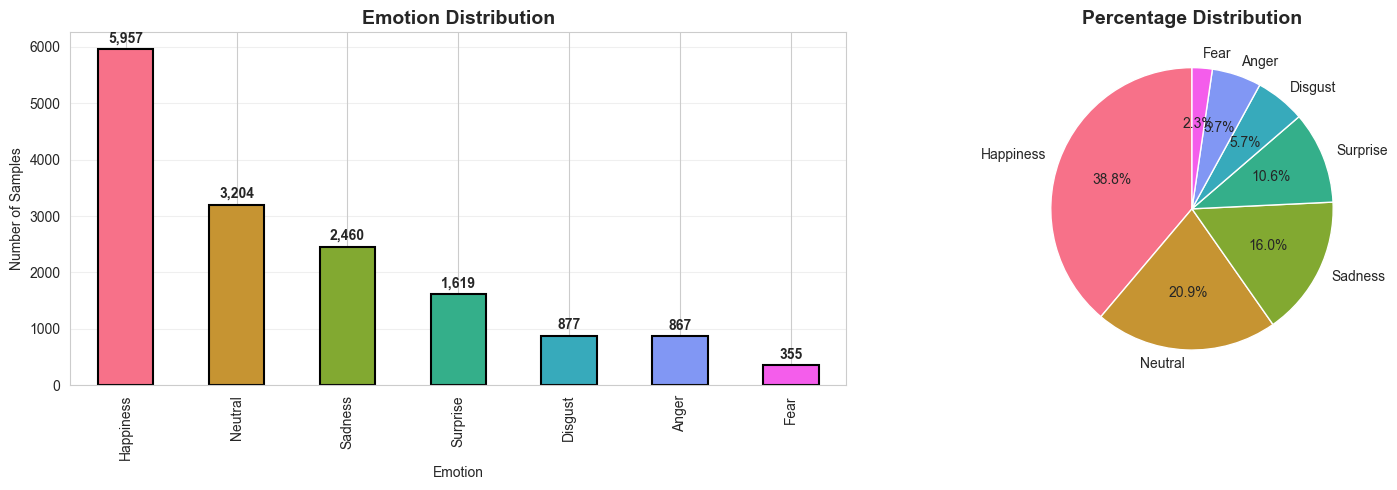

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
emotion_counts = df["emotion_name"].value_counts()
colors = sns.color_palette("husl", len(emotion_counts))

ax = axes[0]
emotion_counts.plot(kind="bar", ax=ax, color=colors, edgecolor="black", linewidth=1.5)
ax.set_title("Emotion Distribution", fontsize=14, fontweight="bold")
ax.set_xlabel("Emotion")
ax.set_ylabel("Number of Samples")
ax.tick_params()
ax.grid(axis="y", alpha=0.3)

for i, v in enumerate(emotion_counts):
    ax.text(i, v + max(emotion_counts) * 0.02, f"{v:,}", ha="center", fontweight="bold")

# Pie chart
ax = axes[1]
emotion_counts.plot(kind="pie", ax=ax, autopct="%1.1f%%", colors=colors, startangle=90)
ax.set_title("Percentage Distribution", fontsize=14, fontweight="bold")
ax.set_ylabel("")

plt.tight_layout()
plt.show()

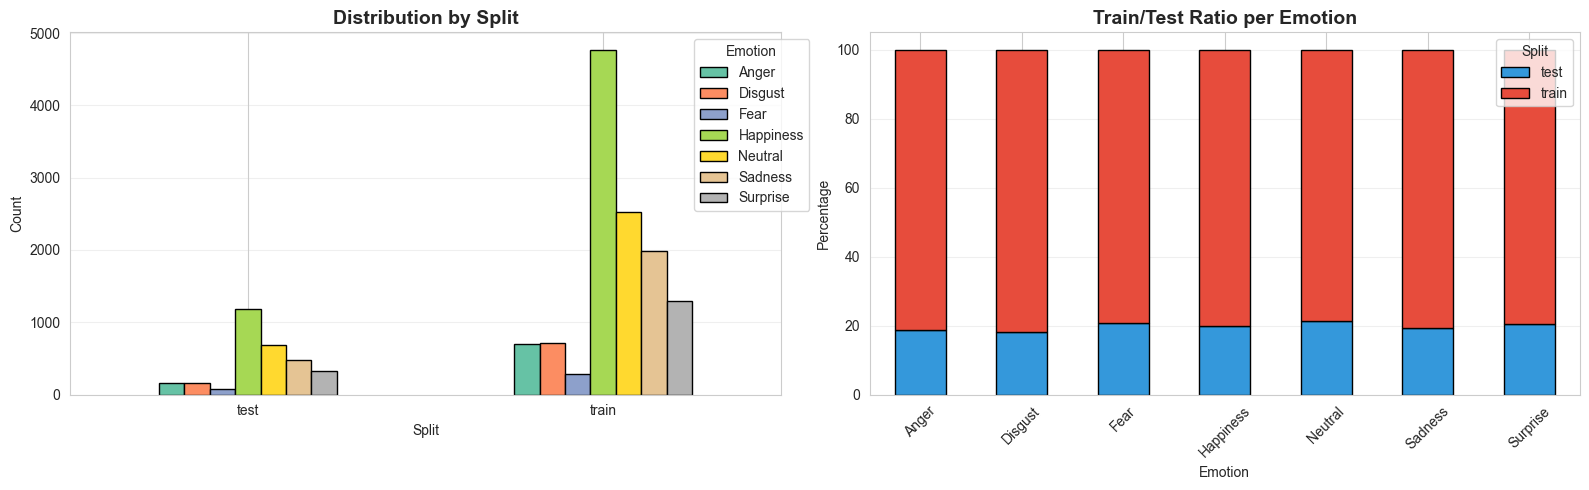

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]
split_counts = df.groupby(["split", "emotion_name"]).size().unstack()
split_counts.plot(kind="bar", ax=ax, colormap="Set2", edgecolor="black", linewidth=1)
ax.set_title("Distribution by Split", fontsize=14, fontweight="bold")
ax.set_xlabel("Split")
ax.set_ylabel("Count")
ax.legend(title="Emotion", bbox_to_anchor=(1.05, 1))
ax.tick_params(axis="x", rotation=0)
ax.grid(axis="y", alpha=0.3)

ax = axes[1]
split_pct = df.groupby(["emotion_name", "split"]).size().unstack(fill_value=0)
split_pct_norm = split_pct.div(split_pct.sum(axis=1), axis=0) * 100
split_pct_norm.plot(
    kind="bar", stacked=True, ax=ax, color=["#3498db", "#e74c3c"], edgecolor="black"
)
ax.set_title("Train/Test Ratio per Emotion", fontsize=14, fontweight="bold")
ax.set_xlabel("Emotion")
ax.set_ylabel("Percentage")
ax.legend(title="Split")
ax.tick_params(axis="x", rotation=45)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
print("CLASS IMBALANCE ANALYSIS")

emotion_counts = df["emotion_name"].value_counts()
max_count = emotion_counts.max()
min_count = emotion_counts.min()

print(f"\nMost frequent: {emotion_counts.index[0]} ({max_count:,})")
print(f"Least frequent: {emotion_counts.index[-1]} ({min_count:,})")
print(f"Imbalance ratio: {max_count / min_count:.2f}:1\n")

for emotion, count in emotion_counts.items():
    ratio = count / max_count
    bar = "█" * int(ratio * 40)
    status = "✓" if ratio > 0.7 else "⚠️" if ratio > 0.5 else "❌"
    print(f"{emotion:12s}: {count:6,d} ({ratio * 100:5.1f}%) {bar:40s} {status}")

CLASS IMBALANCE ANALYSIS

Most frequent: Happiness (5,957)
Least frequent: Fear (355)
Imbalance ratio: 16.78:1

Happiness   :  5,957 (100.0%) ████████████████████████████████████████ ✓
Neutral     :  3,204 ( 53.8%) █████████████████████                    ⚠️
Sadness     :  2,460 ( 41.3%) ████████████████                         ❌
Surprise    :  1,619 ( 27.2%) ██████████                               ❌
Disgust     :    877 ( 14.7%) █████                                    ❌
Anger       :    867 ( 14.6%) █████                                    ❌
Fear        :    355 (  6.0%) ██                                       ❌


In [37]:
class_weights = compute_class_weight(
    "balanced", classes=np.unique(df["emotion_label"]), y=df["emotion_label"]
)

print("\nCLASS WEIGHTS (for balanced training):")
for label, weight in zip(sorted(EMOTION_LABELS.keys()), class_weights):
    emotion_name = EMOTION_LABELS[label]
    print(f"{emotion_name:12s} (Label {label}): {weight:.4f}")


CLASS WEIGHTS (for balanced training):
Surprise     (Label 1): 1.3535
Fear         (Label 2): 6.1726
Disgust      (Label 3): 2.4986
Happiness    (Label 4): 0.3679
Sadness      (Label 5): 0.8908
Anger        (Label 6): 2.5274
Neutral      (Label 7): 0.6839


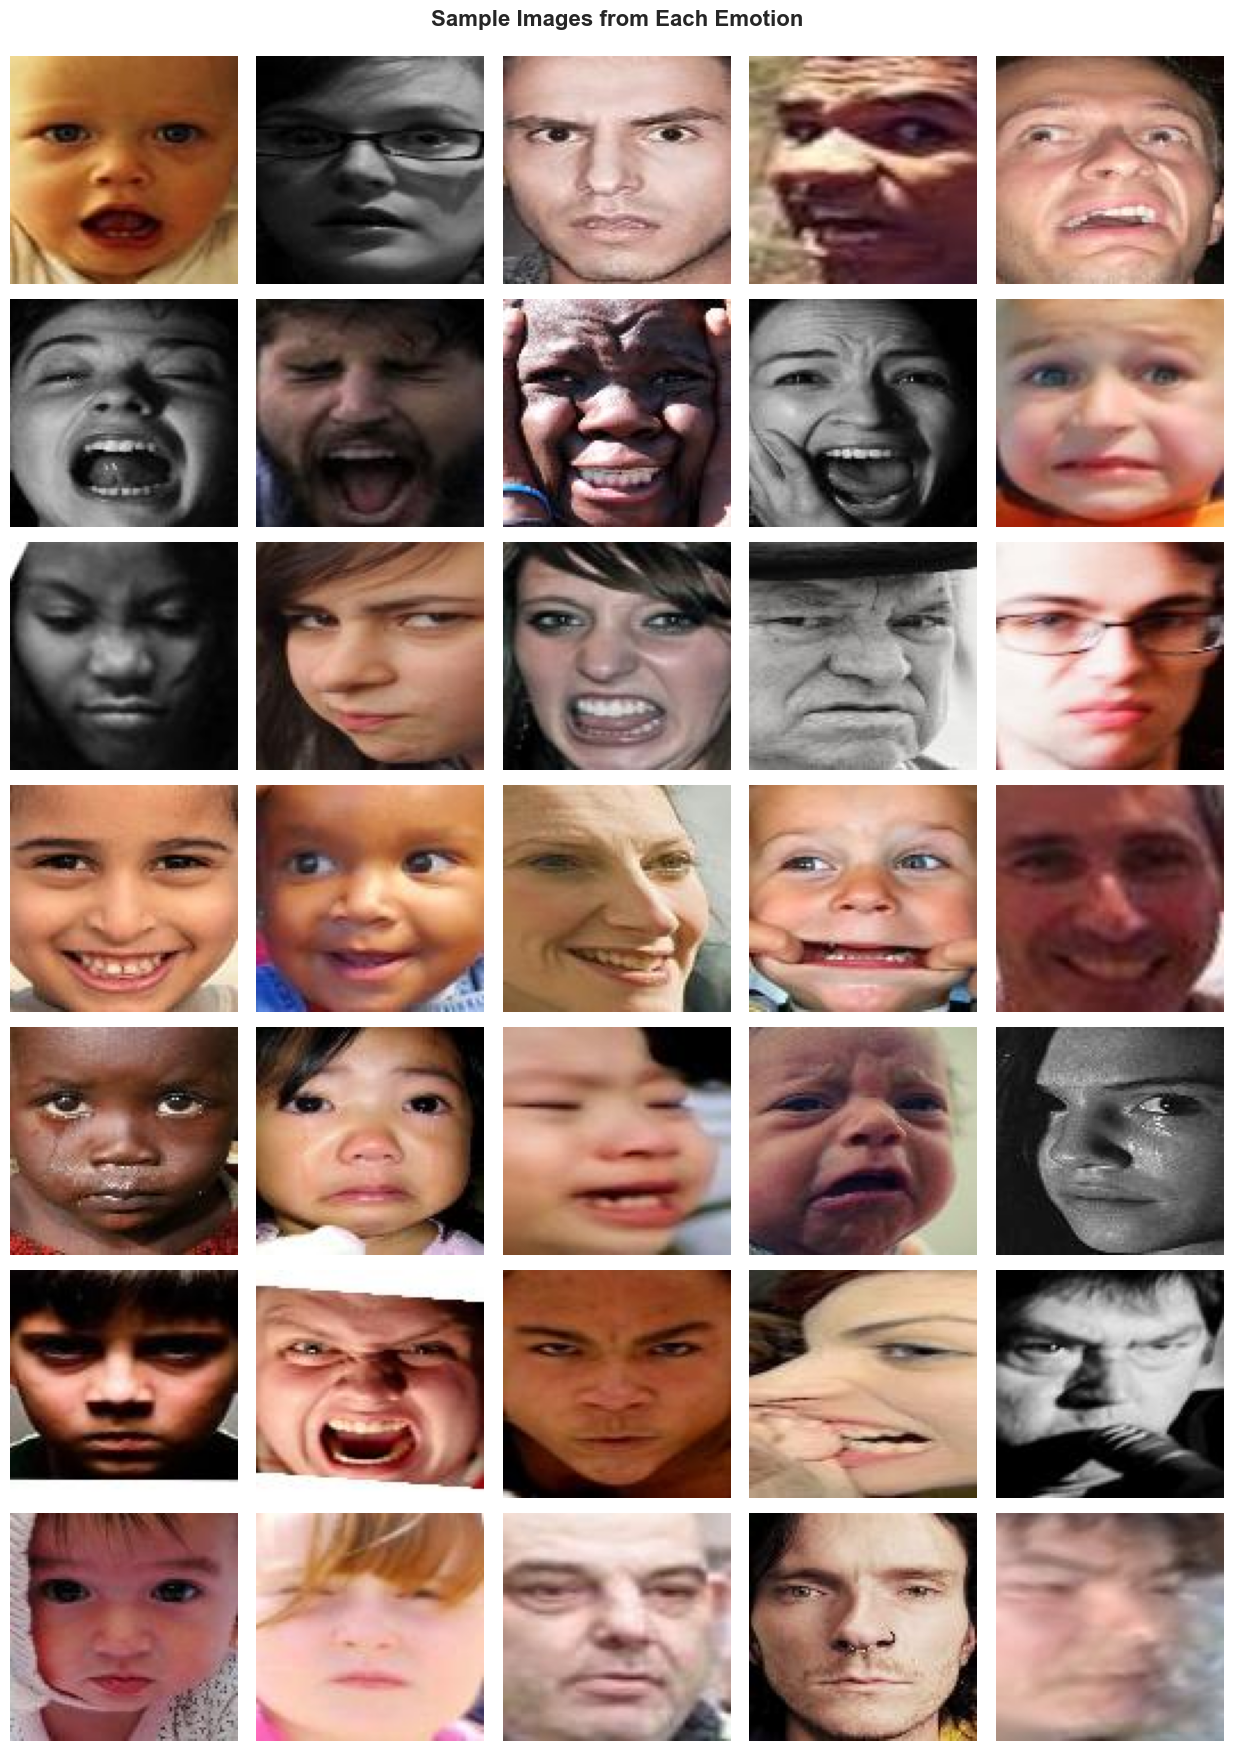

In [38]:
samples_per_class = 5

fig, axes = plt.subplots(7, samples_per_class, figsize=(samples_per_class * 2.5, 17.5))

for idx, (label, emotion_name) in enumerate(sorted(EMOTION_LABELS.items())):
    emotion_samples = df[df["emotion_label"] == label]

    if len(emotion_samples) > 0:
        sample_count = min(samples_per_class, len(emotion_samples))
        emotion_samples = emotion_samples.sample(sample_count, random_state=42)

        for col, (_, row) in enumerate(emotion_samples.iterrows()):
            ax = axes[idx, col]
            img_path = Path(row["full_path"])

            if img_path.exists():
                try:
                    img = Image.open(img_path)
                    ax.imshow(img)
                except Exception:
                    ax.text(0.5, 0.5, "Error", ha="center", va="center")

            else:
                ax.text(0.5, 0.5, "Not Found", ha="center", va="center")

            ax.axis("off")
            if col == 0:
                ax.set_ylabel(emotion_name, fontsize=11, fontweight="bold")

        for col in range(sample_count, samples_per_class):
            axes[idx, col].axis("off")

    else:
        for col in range(samples_per_class):
            axes[idx, col].axis("off")
            if col == 0:
                axes[idx, col].set_ylabel(emotion_name, fontsize=11, fontweight="bold")

plt.suptitle("Sample Images from Each Emotion", fontsize=16, fontweight="bold", y=0.998)
plt.tight_layout()
plt.show()